In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
#from tabulate import tabulate

In [2]:
#Web Scraping - https://pythonprogramminglanguage.com/web-scraping-with-pandas-and-beautifulsoup/
res = requests.get("http://www.fedearroz.com.co/new/precios.php")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
#print( tabulate(df[0], headers='keys', tablefmt='psql') )

In [3]:
#Data Wrangling
arroz=df[0]
arroz.columns = arroz.iloc[0]
arroz = arroz.set_index(['Mes'])
arroz = arroz.drop(['Mes'])
arroz = arroz.rename(index={'Enero': '1', 
                            'Febrero': '2', 
                            'Marzo': '3', 
                            'Abril': '4', 
                            'Mayo': '5',
                            'Junio': '6',
                            'Julio': '7',
                            'Agosto': '8',
                            'Septiembre': '9',
                            'Octubre': '10',
                            'Noviembre': '11',
                            'Diciembre': '12'})
arroz = arroz.reset_index()
arroz = pd.melt(arroz, id_vars=['Mes'],var_name='Year',value_name='Price')
arroz = arroz.rename(columns={'Mes': 'Month'})
arroz['Year'] = arroz['Year'].astype(int)
arroz['Month'] = arroz['Month'].astype(int)
arroz = arroz.dropna()

#pd.to_datetime((df.Y*10000+df.M*100+df.D).apply(str),format='%Y%m%d')
arroz['Date']=pd.to_datetime((arroz.Year*10000+arroz.Month*100+1).apply(str),format='%Y%m%d')

arroz=arroz[['Date','Price']]
arroz['Price']=arroz['Price']/1000

arroz = arroz.set_index('Date')

In [4]:
arroz.head(12)

,Price
Date,
2010-01-01,817.456
2010-02-01,884.395
2010-03-01,796.473
2010-04-01,787.395
2010-05-01,803.395
2010-06-01,853.903
2010-07-01,797.759
2010-08-01,816.705
2010-09-01,848.036


In [5]:
arroz.tail(8)

,Price
Date,
2018-02-01,895.089
2018-03-01,910.929
2018-04-01,919.643
2018-05-01,944.357
2018-06-01,950.000
2018-07-01,936.536
2018-08-01,926.886
2018-09-01,932.571


/home/drivera/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

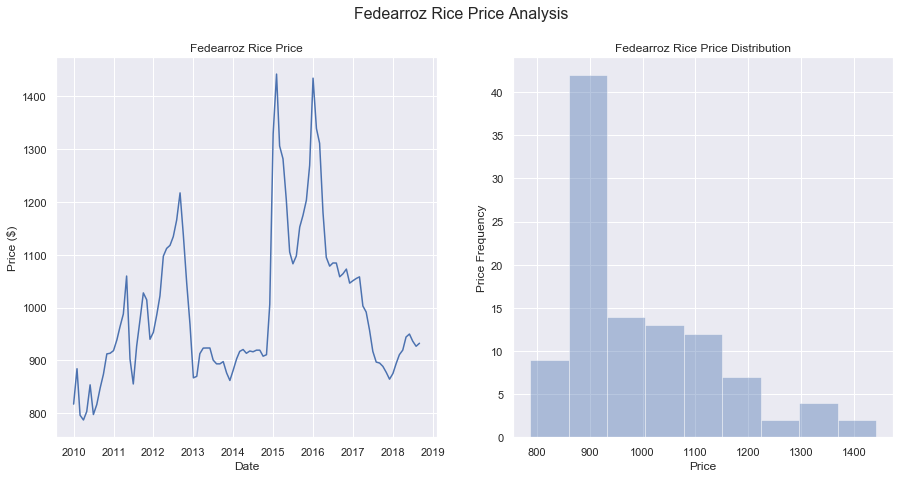

In [6]:
#Timeseries and Distribuition Plot

fig = plt.figure()
sns.set()

f, axs = plt.subplots(2,2,figsize=(15,7))

plt.subplot(121)
sns.lineplot(x=arroz.index, 
             y="Price", 
             data=arroz)
plt.title('Fedearroz Rice Price')
plt.ylabel('Price ($)')

plt.subplot(122)
sns.distplot(arroz.Price,
                    kde=False,
                    color="b")
plt.title('Fedearroz Rice Price Distribution')
plt.ylabel('Price Frequency')

plt.suptitle('Fedearroz Rice Price Analysis', fontsize=16)
plt.show()


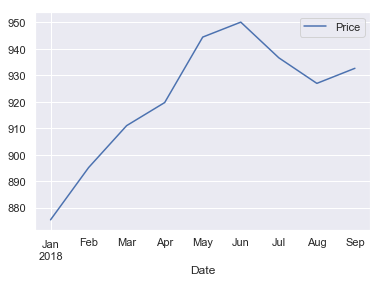

In [7]:
arroz2018 = arroz['2018']
arroz2018.plot()

In [8]:
quarterly = arroz['Price'].resample('Q')
quarterly_mean = quarterly.mean()

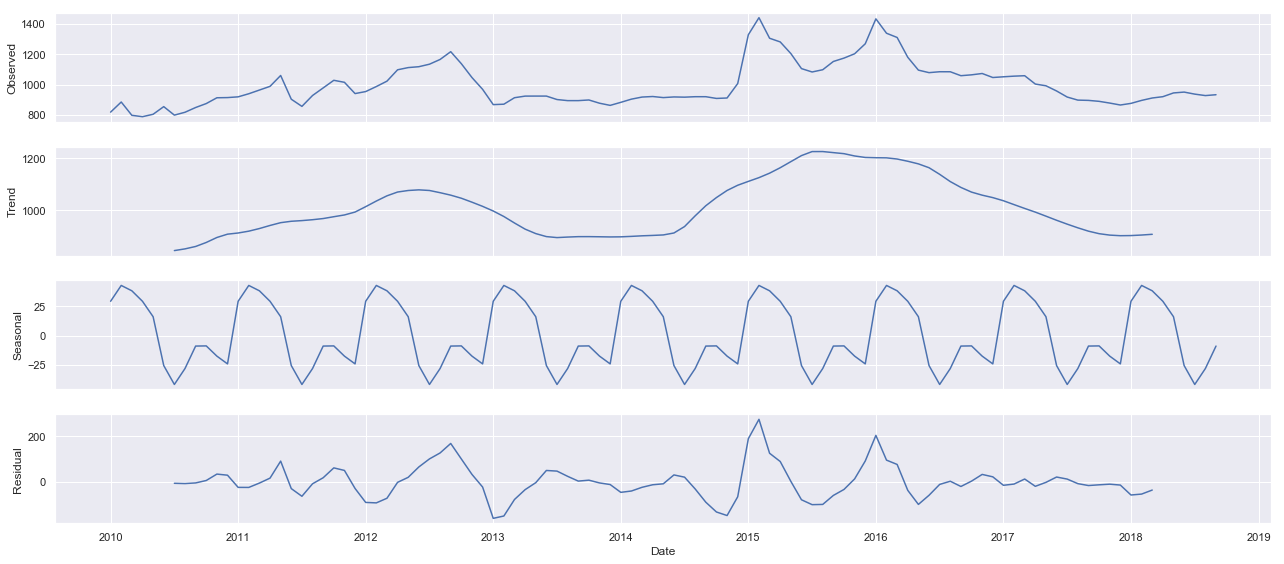

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(arroz['Price'], model='additive')
fig = decomposition.plot()
plt.show()

In [10]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(arroz['Price'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

            

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1735.5641499942549


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1442.554050178263
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1218.0273581157826


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1055.2176897076515
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1232.3633658610358


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1208.5860507094394
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1079.029933758186


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1060.873644067222
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1586.0560608888106


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1312.3365388908614
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1113.5105640417742


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:957.3561514221985
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1138.9477828416684


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1102.388941643316


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:992.0215224745212


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:968.311955753824
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1133.6566637265153
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1001.1543531329779
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1047.9492366826717


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:890.3491956302478
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1014.7822256196353
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1002.696179233882
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:917.1204358034818


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:892.0574798942597
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1108.2443709268944
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:982.7401389986085


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1031.5543358783264


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:864.5313017089725
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1005.2504757877812


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:982.8056411835969
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:907.0515803933498


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:866.5118468024483
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1146.9207964365387


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1013.2442657409744
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1056.5175336672667


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:898.9931459425463
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1016.6482475075885


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1014.946573947723
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:916.04707797252


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:900.8686602789343
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1122.3375413735773


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:994.802043151198
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1040.49583837159


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:871.9472878777535
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1007.1495250569297


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:994.8762470215942


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:904.0157674135726


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:873.9378082485881
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1125.230110283401
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:995.0441812583589
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1045.4652989887986


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:879.7797405622458
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:997.696797884041


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:995.8987436476057
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:898.9269724962875


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:881.6522655680982
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1110.1430692585823


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:984.0526200125338
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1033.1753507474646


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:866.5026265371068
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:997.1927210446364


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:984.5721630357993


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:898.4120540454211


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:868.4807644654321


In [17]:
mod = sm.tsa.statespace.SARIMAX(arroz['Price'],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4924      0.070      6.997      0.000       0.354       0.630
ma.S.L12      -1.0000      0.082    -12.225      0.000      -1.160      -0.840
sigma2      2837.6816   2.88e-05   9.84e+07      0.000    2837.681    2837.682


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


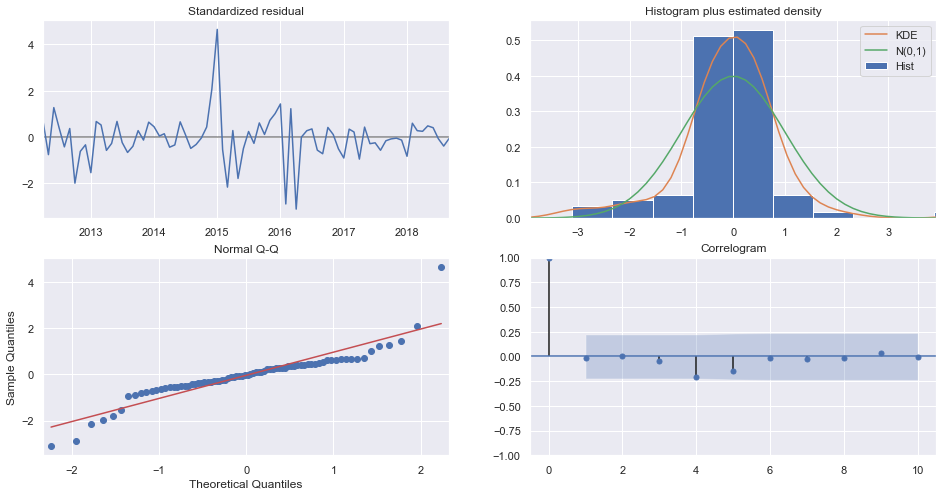

In [18]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

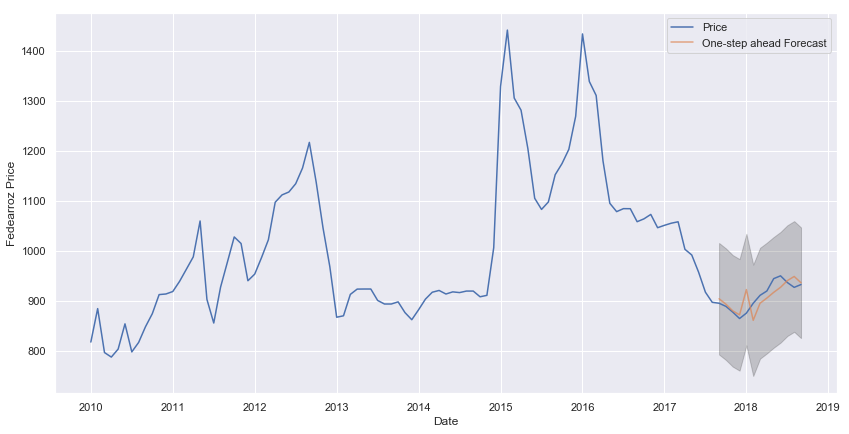

In [19]:
pred = results.get_prediction(start=pd.to_datetime(arroz.index[len(arroz)-12-1]), dynamic=False)
pred_ci = pred.conf_int()

ax = arroz.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Fedearroz Price')
plt.legend()

plt.show()

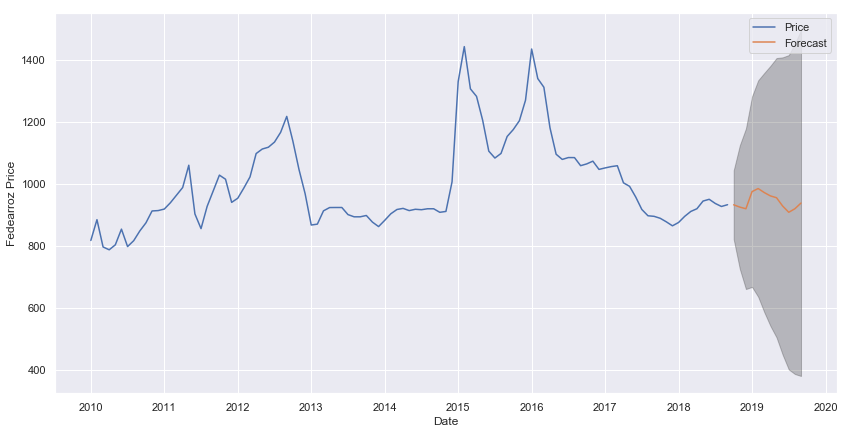

In [20]:
#Producing and visualizing forecasts

pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

ax = arroz.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Fedearroz Price')

plt.legend()
plt.show()

In [21]:
Arroz_Forecast = pd.DataFrame(pred_uc.predicted_mean)
Arroz_Forecast.columns = ['Price']
Arroz_Forecast

,Price
2018-10-01,932.267429
2018-11-01,924.905789
2018-12-01,919.523196
2019-01-01,974.693875
2019-02-01,984.649104
2019-03-01,971.684731
2019-04-01,960.934077
2019-05-01,955.059697
2019-06-01,928.276182
2019-07-01,908.169757
